## 05_Interpolate_CleanBuoyData

* Grab cleaned buoy data created in 04_Interpolate_BuoyData.ipynb
* Interpolate to half-hourly positions
* Save data to csvs to use late in analysis


## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from common_imports import *

import bisect
from pyproj import Geod
g = Geod(ellps='WGS84')

from pandas import Timestamp
from scipy.interpolate import CubicSpline, interp1d


## Functions for flagging data

### Set path to cleaned buoy coordinate data

In [2]:
# set list of path+name of csv files containing coordinates
# or set = None if not adding buoy coordinates
#==============================================================
csv_directory = './data/BuoyCoordinates/'
#==============================================================
csv_files = []
if csv_directory != None:
    files = sorted(list(glob.glob1(csv_directory, "*.csv")));
    print('CSV files:')
    for ii in range(len(files)):
        csv_files.append(csv_directory+files[ii])
        print(csv_directory+files[ii])

CSV files:
./data/BuoyCoordinates/OSU_IT_23_300534061090050_v1.csv
./data/BuoyCoordinates/OSU_IT_24_300534061090090_v1.csv
./data/BuoyCoordinates/OSU_IT_25_300534061091050_v1.csv
./data/BuoyCoordinates/OSU_IT_26_300534061091060_v1.csv
./data/BuoyCoordinates/OSU_IT_27_300534061091070_v1.csv
./data/BuoyCoordinates/OSU_IT_28_300534061093020_v1.csv
./data/BuoyCoordinates/OSU_IT_29_300534061093030_v1.csv
./data/BuoyCoordinates/OSU_IT_30_300534061093040_v1.csv
./data/BuoyCoordinates/OSU_IT_31_300534061093070_v1.csv
./data/BuoyCoordinates/OSU_IT_32_300534061094090_v1.csv
./data/BuoyCoordinates/OSU_IT_33_300534061095060_v1.csv
./data/BuoyCoordinates/OSU_IT_34_1_300534061095090_v1.csv
./data/BuoyCoordinates/OSU_IT_34_2_300534061095090_v1.csv
./data/BuoyCoordinates/OSU_IT_35_300534061096000_v1.csv
./data/BuoyCoordinates/OSU_IT_36_300534061096010_v1.csv
./data/BuoyCoordinates/OSU_IT_37_300534061096020_v1.csv
./data/BuoyCoordinates/OSU_IT_38_300534061096060_v1.csv
./data/BuoyCoordinates/OSU_IT_39_

## Read all buoy data into dictionary

Text(0.5, 1.0, 'buoy deployments (not including data outages)')

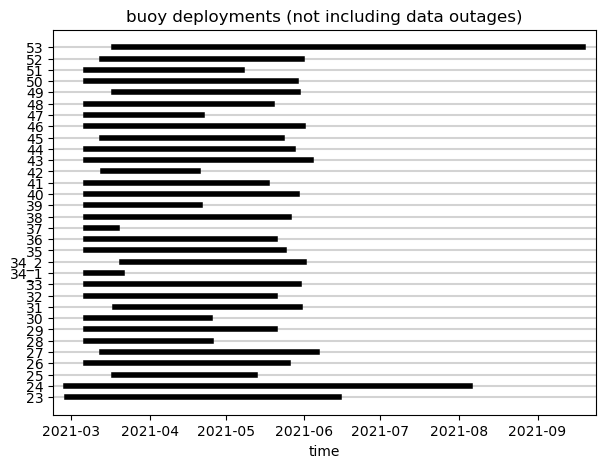

In [3]:
IDs = np.array([])
StartDates = np.array([])
EndDates = np.array([])

# dict to save all buoy data 
# with specific datetime indexing
all_buoy_data = {}

for file in csv_files:
    
    # grab buoy num
    buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
    IDs = np.append(IDs, buoy_num)
    all_buoy_data[buoy_num] = {}
    
    # read in data
    df = pd.read_csv(file)
    
    # save data to dict
    all_buoy_data[buoy_num]['raw_lat'] = df.latitude.values
    all_buoy_data[buoy_num]['raw_lon'] = df.longitude.values
    all_buoy_data[buoy_num]['raw_dates'] = pd.to_datetime(df.datetime.values)

    StartDates = np.append(StartDates, all_buoy_data[buoy_num]['raw_dates'][0])
    EndDates = np.append(EndDates, all_buoy_data[buoy_num]['raw_dates'][-1])
    
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
for ii, ID in enumerate(IDs):
    plt.plot([StartDates[ii], EndDates[ii]], [ID,ID], c='k', lw=4)
ax.set_xlim(np.min(StartDates)-timedelta(days=5), np.max(EndDates)+timedelta(days=5))
for ID in IDs:
    plt.hlines(ID, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', zorder=-1)
ax.set_xlabel('time')
ax.set_title('buoy deployments (not including data outages)')

## Buoy removal 1:
Remove buoys that are removed before end of analysis period

Remove buoys:
 - ended early: ['28' '30' '34_1' '37' '39' '42' '47']
 - started late: ['34_2']


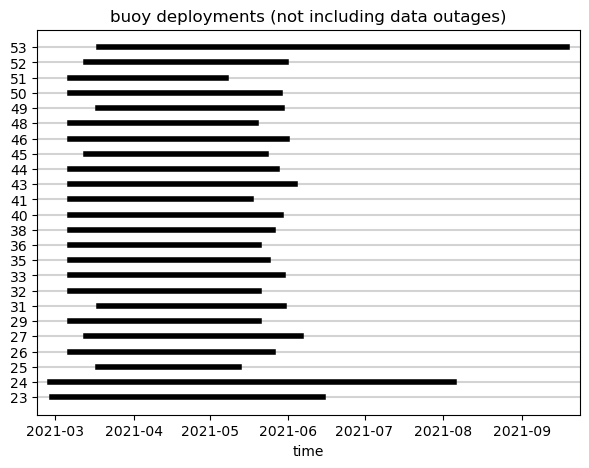

In [4]:
ended_early = IDs[np.where(EndDates < Timestamp('2021-05-01 00:00:00'))]
started_late = IDs[np.where(StartDates > Timestamp('2021-03-20 00:00:00'))]
print(f'Remove buoys:')
print(' - ended early:', ended_early)
print(' - started late:', started_late)

keep_buoys = []
for ID in IDs:
    if (ID not in ended_early) and (ID not in started_late):
        keep_buoys.append(ID)
        
        
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
for ii, ID in enumerate(keep_buoys):
    plt.plot([StartDates[np.where(IDs==keep_buoys[ii])[0][0]], 
              EndDates[np.where(IDs==keep_buoys[ii])[0][0]]], [ID,ID], c='k', lw=4)
ax.set_xlim(np.min(StartDates)-timedelta(days=5), np.max(EndDates)+timedelta(days=5))
for ID in keep_buoys:
    plt.hlines(ID, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', zorder=-1)
ax.set_xlabel('time');
ax.set_title('buoy deployments (not including data outages)');

## Buoy removal 2: 
---
### Find which buoys to remove due to close proximity to other buoys
(Remove 2nd buoy (larger short index) of pair if buoy pair found within 2 km of one another)

<IPython.core.display.Javascript object>


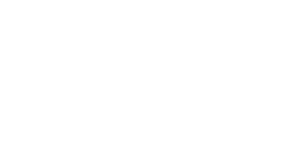

Buoy pairs:
-----------
26 -- 44

Remove buoys:
 - too close: ['44']


In [5]:
# look on specific date and find buoy pairs within 2 km of one another  
spec_date = datetime(2021, 4, 1, 0, 0)
dist_thresh = 2000*units('m')

time_slice_lats = np.array([])
time_slice_lons = np.array([])

close_buoys = []

for buoy in keep_buoys:
    
    date_index = bisect.bisect_left(all_buoy_data[buoy]['raw_dates'], spec_date)
    time_slice_lats = np.append(time_slice_lats, all_buoy_data[buoy]['raw_lat'][date_index])
    time_slice_lons = np.append(time_slice_lons, all_buoy_data[buoy]['raw_lon'][date_index])
    
%matplotlib notebook
fig, ax = plt.subplots(figsize=(4,4))
ax.set_ylabel('latitude');
ax.set_xlabel('longitude');
ax.scatter(time_slice_lons, time_slice_lats, c='gray', s=10)

print(f'Buoy pairs:\n-----------')
for TT in range(len(keep_buoys)):
    for tt in range(len(keep_buoys)):
        lons1,lats1 = time_slice_lons[TT], time_slice_lats[TT]
        lons2,lats2 = time_slice_lons[tt], time_slice_lats[tt]
        
        # compute forward and back azimuths, plus distance
        az12,az21,distance = g.inv(lons1, lats1, lons2, lats2)
        if distance*units('m') < dist_thresh:
            if TT != tt:
                buoy1 = keep_buoys[TT]
                buoy2 = keep_buoys[tt]
                
                ax.text(lons1,lats1,f' {buoy1}', c='k')
                
                if int(buoy1) < int(buoy2):
                    close_buoys.append(buoy2)
                    print(f'{buoy1} -- {buoy2}')
                    ax.plot([lons1,lons2],[lats1,lats2],  c='k', zorder=-1)
                    ax.scatter(lons2,lats2, alpha=1, facecolor='dodgerblue', edgecolor='k', s=10)
                    ax.scatter(lons1,lats1, alpha=1, facecolor='dodgerblue', edgecolor='k', s=10)
                
print(f'\nRemove buoys:')
print(' - too close:', close_buoys)

final_keep_buoys = []
for ID in keep_buoys:
    if (ID not in close_buoys):
        final_keep_buoys.append(ID)

In [6]:
print(f'Final {len(final_keep_buoys)} buoys to keep: {final_keep_buoys}')

Final 23 buoys to keep: ['23', '24', '25', '26', '27', '29', '31', '32', '33', '35', '36', '38', '40', '41', '43', '45', '46', '48', '49', '50', '51', '52', '53']


## Interpolate remaining buoy data to half-hourly

### Create list of desired half-hourly dates

In [7]:
#========================================================================
date_i = datetime(year=2021, month=2, day = 25, hour=0, minute = 0)
date_f = datetime(year=2021, month=6, day = 1, hour=0, minute = 0)
#========================================================================

# create list of desired dates
total_halfhours = ((date_f - date_i).days)*48 + 1
desired_dates = np.array([date_i + timedelta(minutes=30*halfhours) for halfhours in range(total_halfhours)])
desired_dates = pd.to_datetime(desired_dates)


## Plot cubic and linear spline interpolations for individual buoy

In [8]:
#==============
buoy = '41'
#==============

raw_dates = pd.to_datetime(np.copy(all_buoy_data[buoy]['raw_dates']))
raw_lon = np.copy(all_buoy_data[buoy]['raw_lon'])
raw_lat = np.copy(all_buoy_data[buoy]['raw_lat'])

# check for huge gap in data at end of timeseries becuase it blows up spline fit
# if huge gap end, crop last few values off end
thresh = 12*units('hours')
flag_huge_gap = np.where(np.diff(raw_dates).astype(int)*units('nanoseconds').to('minutes') > thresh)[0]
if len(flag_huge_gap) > 0:
    print(f'{len(flag_huge_gap)} gap{"s"*(len(flag_huge_gap)>1)} of 12+ hours')
    # if within last 10 points in raw dates, crop the huge gap off the end
    if flag_huge_gap[0] > len(raw_dates)-10:
        print(f'>>> crop last {len(raw_dates)-flag_huge_gap[0]-1} points')
        raw_dates = raw_dates[:flag_huge_gap[0]+1]
        raw_lon = raw_lon[:flag_huge_gap[0]+1]
        raw_lat = raw_lat[:flag_huge_gap[0]+1]

# find where in desired dates the first and last reported data are found
ind_i = bisect.bisect_left(desired_dates, raw_dates[0])
ind_f = bisect.bisect_left(desired_dates, raw_dates[-1])

# timesteps (seconds, easier for interpolation to use this than true time)
t = (raw_dates - desired_dates[ind_i-1]).total_seconds()
t_new = (desired_dates[ind_i:ind_f] - desired_dates[ind_i-1]).total_seconds()

# create interpolation functions
cs_lon = CubicSpline(t, raw_lon)
linear_lon = interp1d(t, raw_lon) 

cs_lat = CubicSpline(t, raw_lat)
linear_lat = interp1d(t, raw_lat) 

1 gap of 12+ hours
>>> crop last 1 points


### Plot

<IPython.core.display.Javascript object>


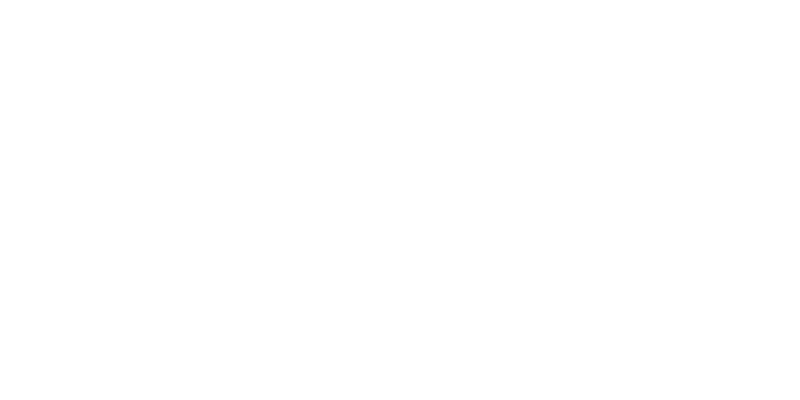

In [9]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, figsize=(8,4))

axs[0].set_title(f'buoy {buoy}')

axs[0].set_ylabel('lat')
axs[1].set_ylabel('lon')

# axs[0].set_xlim(desired_dates[0], desired_dates[-1])
# axs[1].set_xlim(desired_dates[0], desired_dates[-1])


axs[0].plot(raw_dates, raw_lat, marker='.', ms=15, c='lightgray', label='raw clean data')
axs[0].plot(desired_dates[ind_i:ind_f], cs_lat(t_new), marker='.', ms=10, c='dodgerblue', label='spline')
axs[0].plot(desired_dates[ind_i:ind_f], linear_lat(t_new), marker='.', ms=5, c='darkorange', label='linear')
axs[0].legend()

axs[1].plot(raw_dates, raw_lon, marker='.', ms=15, c='lightgray')
axs[1].plot(desired_dates[ind_i:ind_f], cs_lon(t_new), marker='.', ms=10, c='dodgerblue')
axs[1].plot(desired_dates[ind_i:ind_f], linear_lon(t_new), marker='.', ms=5, c='darkorange')


<IPython.core.display.Javascript object>


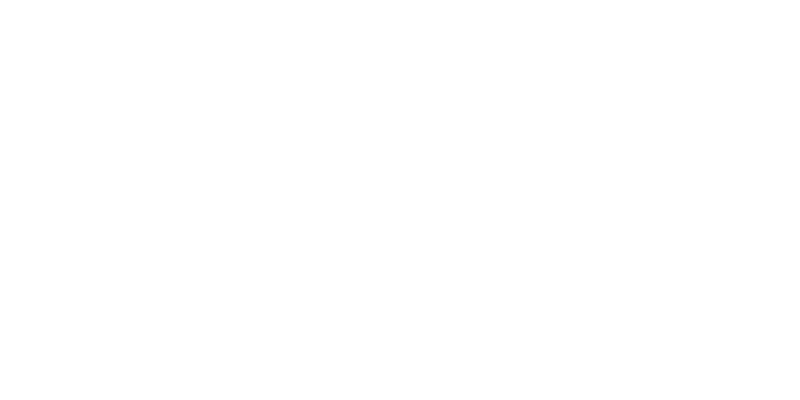

In [10]:
fig, axs = plt.subplots(2,1, figsize=(8,4))

axs[0].set_title(f'buoy {buoy}\ndifference between cubic spline and linear interpolation')

axs[0].set_ylabel('diff lat')
axs[1].set_ylabel('diff lon')

axs[0].plot(desired_dates[ind_i:ind_f], cs_lat(t_new) - linear_lat(t_new), marker='.', ms=10, c='dodgerblue')
axs[1].plot(desired_dates[ind_i:ind_f], cs_lon(t_new) - linear_lon(t_new), marker='.', ms=10, c='dodgerblue')

# Loop over all buoys to keep

In [11]:
final_buoy_data = {}

for buoy in final_keep_buoys:

    final_buoy_data[buoy] = {}
    final_buoy_data[buoy]['lat'] = {}
    final_buoy_data[buoy]['lon'] = {}
    
    # open raw data
    raw_dates = pd.to_datetime(np.copy(all_buoy_data[buoy]['raw_dates']))
    raw_lon = np.copy(all_buoy_data[buoy]['raw_lon'])
    raw_lat = np.copy(all_buoy_data[buoy]['raw_lat'])

    # check for huge gap in data at end of timeseries becuase it blows up spline fit
    # if huge gap end, crop last few values off end
    thresh = 12*units('hours')
    flag_huge_gap = np.where(np.diff(raw_dates).astype(int)*units('nanoseconds').to('minutes') > thresh)[0]
    if len(flag_huge_gap) > 0:
        print(f'buoy {buoy} has {len(flag_huge_gap)} gap{"s"*(len(flag_huge_gap)>1)} of 12+ hours')
        # if within last 10 points in raw dates, crop the huge gap off the end
        if flag_huge_gap[0] > len(raw_dates)-10:
            print(f'>>> crop last {len(raw_dates)-flag_huge_gap[0]-1} points')
            raw_dates = raw_dates[:flag_huge_gap[0]+1]
            raw_lon = raw_lon[:flag_huge_gap[0]+1]
            raw_lat = raw_lat[:flag_huge_gap[0]+1]
    
    # find where in desired dates the first and last reported data are found
    ind_i = bisect.bisect_left(desired_dates, raw_dates[0])
    ind_f = bisect.bisect_left(desired_dates, raw_dates[-1])

    # timesteps (seconds, easier for interpolation to use this than true time)
    t = (raw_dates - desired_dates[ind_i-1]).total_seconds()
    t_new = (desired_dates[ind_i:ind_f] - desired_dates[ind_i-1]).total_seconds()

    # create interpolation functions
    cs_lon = CubicSpline(t, raw_lon)
    linear_lon = interp1d(t, raw_lon) 

    cs_lat = CubicSpline(t, raw_lat)
    linear_lat = interp1d(t, raw_lat) 
    
    
    # linear interpolation
    #---------------------
    # lats
    lin_lat = np.empty(len(desired_dates))
    lin_lat[:] = np.nan
    lin_lat[ind_i:ind_f] = linear_lat(t_new)

    # lons
    lin_lon = np.empty(len(desired_dates))
    lin_lon[:] = np.nan
    lin_lon[ind_i:ind_f] = linear_lon(t_new)

    # cubic interpolation
    #--------------------
    # lats
    cub_lat = np.empty(len(desired_dates))
    cub_lat[:] = np.nan
    cub_lat[ind_i:ind_f] = cs_lat(t_new)

    # lons
    cub_lon = np.empty(len(desired_dates))
    cub_lon[:] = np.nan
    cub_lon[ind_i:ind_f] = cs_lon(t_new)


    # save to final data array
    final_buoy_data[buoy]['lat']['linear'] = lin_lat
    final_buoy_data[buoy]['lon']['linear'] = lin_lon
    
    final_buoy_data[buoy]['lat']['cubic'] = cub_lat
    final_buoy_data[buoy]['lon']['cubic'] = cub_lon

buoy 35 has 1 gap of 12+ hours
>>> crop last 1 points
buoy 41 has 1 gap of 12+ hours
>>> crop last 1 points
buoy 51 has 1 gap of 12+ hours
>>> crop last 3 points
buoy 53 has 1 gap of 12+ hours
>>> crop last 1 points


<IPython.core.display.Javascript object>


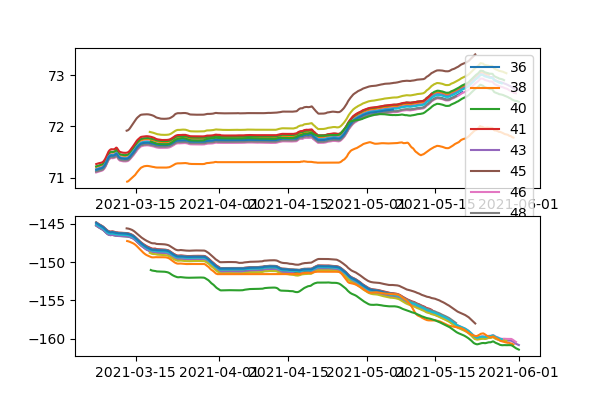

In [14]:
fig, axs = plt.subplots(2,1, figsize=(6,4))

for buoy in list(final_buoy_data.keys())[10:]:
    axs[0].plot(desired_dates, final_buoy_data[buoy]['lat']['cubic'], label=buoy)
    axs[1].plot(desired_dates, final_buoy_data[buoy]['lon']['cubic'])
    
axs[0].legend()

## Save data

## Save to file

In [25]:
# grab short buoy numbers
short_buoy_nums = list(final_buoy_data.keys())
    
all_lats = np.array([])
all_lons = np.array([])

for buoy in final_buoy_data:
    all_lats = np.append(all_lats, final_buoy_data[buoy]['lat']['cubic'])
    all_lons = np.append(all_lons, final_buoy_data[buoy]['lon']['cubic'])
    
buoy_lat_grid = np.reshape(all_lats, (len(final_buoy_data), len(desired_dates)))
buoy_lon_grid = np.reshape(all_lons, (len(final_buoy_data), len(desired_dates)))

OUTPUT_FILE = './data/BuoyCoordinates_cln_v0.nc'

ds = xr.Dataset(
    
    data_vars=dict(
    latitude=(["buoyID", "time"], buoy_lat_grid, {"units": "degree_north"}),
    longitude=(["buoyID", "time"], buoy_lon_grid, {"units": "degree_east"}),
    ),
    
    coords=dict(
        time = (["time"], desired_dates), 
        buoyID = (["buoyID"], short_buoy_nums)),
    
    attrs=dict(description="half-hourly interpolated buoy positions from cleaned HutchingsEtAl2023 data doi:10.18739/A2J678Z4N "),
    )

if os.path.isfile(OUTPUT_FILE):
    print(f'File already exists!!! Delete old version before saving new one.')
else:
    ds.to_netcdf(path=OUTPUT_FILE, mode='w', format="NETCDF4")  
    
    

File already exists!!! Delete old version before saving new one.


In [ ]:
# interp_lats = np.array([])
# interp_lons = np.array([])


# for date_c in desired_dates:

#     # get index before date
#     idx = bisect.bisect_left(raw_dates, date_c)

#     # if desired date is before first reported date,
#     # fill position with nans
#     if idx == 0:
#         lat_c = np.nan
#         lon_c = np.nan

#     # or if reaching or surpassing last reported date
#     elif idx == len(raw_dates):
#         lat_c = np.nan
#         lon_c = np.nan
        
#     else:
#         date_i = raw_dates[idx-1] # date before
#         lon_i  = raw_lon[idx-1]   # coordinates before
#         lat_i  = raw_lat[idx-1]

#         date_f = raw_dates[idx] # date after
#         lon_f  = raw_lon[idx]   # coordinates after
#         lat_f  = raw_lat[idx]

#         dt = ((date_f - date_i).total_seconds()/60) # minutes
#         dx = lon_f - lon_i
#         dy = lat_f - lat_i

#         # fractions of time step between date_f and date_i 
#         # occuring between date_i and date_c
#         dt_frac_i = ((date_c - date_i).total_seconds()/60)/dt

#         # simple zonal and meridional interpolation
#         # fraction of zonal and meridional displacements from (i) to (f)
#         lat_c = lat_i + (dt_frac_i * dy)
#         lon_c = lon_i + (dt_frac_i * dx)

#     interp_lats = np.append(interp_lats, lat_c)
#     interp_lons = np.append(interp_lons, lon_c)